In [ ]:
# ============================================================
# 🔰 Deployment: Predict Quadrant (Cassandra + Auto Compute Indicators + Best Model)
# ============================================================

from cassandra.cluster import Cluster
import pandas as pd
import numpy as np
import joblib
import os
from tensorflow.keras.models import load_model

# ============================================================
# 1️⃣ CONNECT CASSANDRA
# ============================================================
def connect_cassandra():
    cluster = Cluster(['127.0.0.1'])
    session = cluster.connect()
    session.set_keyspace('data_stock')
    return session


# ============================================================
# 2️⃣ LOAD DATA FROM CASSANDRA
# ============================================================
def get_stock_data(session, symbol):
    q_price = f"""
        SELECT time, close_price, high_price, low_price, open_price, value
        FROM candlestick_data
        WHERE symbol='{symbol}'
        LIMIT 300;
    """

    q_vol = f"""
        SELECT time, volume
        FROM candlestick1_1068_data
        WHERE symbol='{symbol}'
        LIMIT 300;
    """

    q_fund = f"""
        SELECT eps, pe, pbv, percentyield
        FROM financal_data_fromsettradeAPI
        WHERE symbol='{symbol}'
        LIMIT 1;
    """

    df_price = pd.DataFrame(session.execute(q_price).all())
    df_vol = pd.DataFrame(session.execute(q_vol).all())
    fund = session.execute(q_fund).one()

    if df_price.empty or df_vol.empty or not fund:
        raise ValueError(f"❌ ไม่มีข้อมูลครบสำหรับ {symbol}")

    df_price = df_price.sort_values("time")
    df_vol = df_vol.sort_values("time")

    df = pd.merge(df_price, df_vol, on="time", how="inner")
    df["marketcap"] = df["close_price"] * df["volume"]

    return df, fund._asdict()


# ============================================================
# 3️⃣ COMPUTE INDICATORS (EMA & RSI)
# ============================================================
def compute_indicators(df):
    df["ema5"] = df["close_price"].ewm(span=5, adjust=False).mean()
    df["ema15"] = df["close_price"].ewm(span=15, adjust=False).mean()
    df["ema35"] = df["close_price"].ewm(span=35, adjust=False).mean()
    df["ema89"] = df["close_price"].ewm(span=89, adjust=False).mean()
    df["ema200"] = df["close_price"].ewm(span=200, adjust=False).mean()

    delta = df["close_price"].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df["rsi"] = 100 - (100 / (1 + rs))

    df = df.dropna().reset_index(drop=True)
    return df


# ============================================================
# 4️⃣ LOAD BEST MODEL (Auto-detect Keras or Sklearn)
# ============================================================
def load_best_model():
    model_path_h5 = "C:/Users/Admin/OneDrive/Desktop/Stock-quadrant-quantitative-analysis-using-deep-learning-classification/1.Final_file/3.Data_preparation,4.Modelling/deploy_model_deep/best_model_deep.h5"
    model_path_pkl = "C:/Users/Admin/OneDrive/Desktop/Stock-quadrant-quantitative-analysis-using-deep-learning-classification/1.Final_file/3.Data_preparation,4.Modelling/deploy_model_deep/best_model.pkl"
    scaler_path = "C:/Users/Admin/OneDrive/Desktop/Stock-quadrant-quantitative-analysis-using-deep-learning-classification/1.Final_file/3.Data_preparation,4.Modelling/deploy_model_deep/scaler.pkl"
    encoder_path = "C:/Users/Admin/OneDrive/Desktop/Stock-quadrant-quantitative-analysis-using-deep-learning-classification/1.Final_file/3.Data_preparation,4.Modelling/deploy_model_deep/label_encoder.pkl"

    if not os.path.exists(scaler_path) or not os.path.exists(encoder_path):
        raise FileNotFoundError("❌ Missing scaler or label_encoder in deploy_model/")

    scaler = joblib.load(scaler_path)
    le = joblib.load(encoder_path)

    if os.path.exists(model_path_h5):
        model = load_model(model_path_h5)
        model_type = "keras"
    elif os.path.exists(model_path_pkl):
        model = joblib.load(model_path_pkl)
        model_type = "sklearn"
    else:
        raise FileNotFoundError("❌ ไม่พบไฟล์โมเดลใน deploy_model/")

    print(f"✅ Loaded best model ({model_type.upper()}) successfully!")
    return model, scaler, le, model_type


# ============================================================
# 5️⃣ PREDICT FUNCTION
# ============================================================
def predict_quadrant(symbol):
    session = connect_cassandra()
    df, fund_data = get_stock_data(session, symbol)
    df = compute_indicators(df)

    last = df.iloc[-1]
    input_data = {
        **fund_data,
        "marketcap": last["marketcap"],
        "close_price": last["close_price"],
        "high_price": last["high_price"],
        "low_price": last["low_price"],
        "open_price": last["open_price"],
        "value": last["value"],
        "ema5": last["ema5"],
        "ema15": last["ema15"],
        "ema35": last["ema35"],
        "ema89": last["ema89"],
        "ema200": last["ema200"],
        "rsi": last["rsi"]
    }

    features = ["eps", "pe", "pbv", "percentyield", "marketcap",
                "close_price", "high_price", "low_price", "open_price",
                "value", "ema5", "ema15", "ema35", "ema89", "ema200", "rsi"]

    X = np.array([[input_data[f] for f in features]])

    model, scaler, le, model_type = load_best_model()

    X_scaled = scaler.transform(X)

    if model_type == "keras":
        y_pred = model.predict(X_scaled)
        y_class = np.argmax(y_pred, axis=1)
    else:
        y_class = model.predict(X_scaled)

    quadrant = le.inverse_transform([int(y_class[0])])[0]
    return quadrant, input_data


# ============================================================
# 6️⃣ TEST PREDICTION
# ============================================================
if __name__ == "__main__":
    try:
        symbol = input("🔎 พิมพ์ชื่อหุ้น (เช่น AOT): ").upper()
        quadrant, used_data = predict_quadrant(symbol)

        print(f"\n✅ หุ้น {symbol} อยู่ใน Quadrant → {quadrant}")
        print("\n📊 ข้อมูลที่ใช้ในการวิเคราะห์:")
        for k, v in used_data.items():
            try:
                print(f"  {k:15s}: {float(v):.2f}")
            except:
                print(f"  {k:15s}: {v}")

    except Exception as e:
        print("❌ เกิดข้อผิดพลาด:", e)


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.5.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


✅ Loaded best model (KERAS) successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step

✅ หุ้น AOT อยู่ใน Quadrant → Ab

📊 ข้อมูลที่ใช้ในการวิเคราะห์:
  eps            : 1.00
  pe             : 29.10
  pbv            : 4.25
  percentyield   : 2.09
  marketcap      : 1266001848.00
  close_price    : 72.00
  high_price     : 73.00
  low_price      : 72.00
  open_price     : 72.75
  value          : 0.00
  ema5           : 72.39
  ema15          : 71.91
  ema35          : 71.51
  ema89          : 71.55
  ema200         : 71.91
  rsi            : 59.26


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Traceback (most recent call last):
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\cassandra\cluster.py", line 3577, in _reconnect_internal
    return self._try_connect(host)
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\cassandra\cluster.py", line 3599, in _try_connect
    connection = self._cluster.connection_factory(host.endpoint, is_control_connection=True)
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\cassandra\cluster.py", line 1670, in connection_factory
    return self.connection_class.factory(endpoint, self.connect_timeout, *args, **kwargs)
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\cassandra\connection.py", line 846, in factory
    conn = cls(endpoint, *args, **kwargs)
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\cassandra\io\asyncorereactor.py", line 353, in __init__
    self._connect_socket()
  File 

In [ ]:
# ============================================================
# 🔰 Predict Multiple Stocks and Combine into DataFrame
# ============================================================

import pandas as pd

# สมมติว่าคุณมีฟังก์ชันนี้จากขั้นตอนก่อนหน้าแล้ว
# def predict_quadrant(symbol): -> return quadrant, input_data

# -----------------------------
# 1. รายชื่อหุ้นที่ต้องการทำนาย
# -----------------------------
symbols = ["DELTA", "PTT", "AOT", "ADVANC", "KBANK", 
           "TRUE", "GULF", "SCB", "KTC", "KTB", "CPALL"]

# -----------------------------
# 2. วนลูปทำนายหุ้นแต่ละตัว
# -----------------------------
results = []
for sym in symbols:
    try:
        quadrant, data_used = predict_quadrant(sym)
        row = {"Symbol": sym, "Quadrant": quadrant}
        row.update(data_used)  # รวมฟีเจอร์ที่ใช้ในการทำนาย (optional)
        results.append(row)
        print(f"✅ {sym} → {quadrant}")
    except Exception as e:
        print(f"❌ {sym}: {e}")

# -----------------------------
# 3. รวมผลเป็น DataFrame
# -----------------------------
df_pred = pd.DataFrame(results)

# แสดงเฉพาะคอลัมน์สำคัญ
cols_show = ["Symbol", "Quadrant", "eps", "pe", "pbv", "percentyield", 
             "marketcap", "close_price", "ema5", "ema15", "ema35", "rsi"]
df_show = df_pred[cols_show].round(2)

print("\n📊 ผลการทำนายทั้งหมด:")
display(df_show)


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.5.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


✅ Loaded best model (KERAS) successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


✅ DELTA → Ac


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.5.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


✅ Loaded best model (KERAS) successfully!


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


✅ PTT → Ad


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.5.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


✅ Loaded best model (KERAS) successfully!


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


✅ AOT → Ab


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.5.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


✅ Loaded best model (KERAS) successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


✅ ADVANC → Ac


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.5.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


✅ Loaded best model (KERAS) successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


✅ KBANK → Ab


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.5.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


✅ Loaded best model (KERAS) successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


✅ TRUE → Ab


❌ GULF: ❌ ไม่มีข้อมูลครบสำหรับ GULF


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.5.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


✅ Loaded best model (KERAS) successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


✅ SCB → Ab


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.5.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


✅ Loaded best model (KERAS) successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


✅ KTC → Ab


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.5.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


✅ Loaded best model (KERAS) successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


✅ KTB → Ad


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.5.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


✅ Loaded best model (KERAS) successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
✅ CPALL → Ab

📊 ผลการทำนายทั้งหมด:


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


,Symbol,Quadrant,eps,pe,pbv,percentyield,marketcap,close_price,ema5,ema15,ema35,rsi
0,DELTA,Ac,0.81,100.50,21.75,0.31,5.194120e+08,109.00,108.85,107.59,106.02,58.73
1,PTT,Ad,1.57,12.86,0.80,6.62,1.744858e+09,34.75,35.07,35.33,34.93,30.77
2,AOT,Ab,1.00,29.10,4.25,2.09,1.266002e+09,72.00,72.39,71.91,71.51,59.26
3,ADVANC,Ac,7.25,21.85,8.51,3.65,9.322627e+08,213.00,215.24,217.95,218.91,31.82
4,KBANK,Ab,5.67,8.09,0.68,7.19,8.519348e+08,130.50,130.65,130.06,129.43,62.07
5,TRUE,Ab,0.11,0.00,5.08,0.00,8.345208e+08,8.70,8.54,8.43,8.20,52.38
6,SCB,Ab,7.51,9.03,0.90,8.12,7.943464e+08,118.50,117.80,116.09,113.50,76.19
7,KTC,Ab,1.46,9.46,1.78,4.76,2.434419e+08,47.00,47.87,47.60,47.57,55.56
8,KTB,Ad,0.84,7.54,0.74,6.44,8.139685e+08,19.00,19.28,19.52,19.64,35.48
9,CPALL,Ab,1.57,14.91,3.18,3.00,1.141302e+09,64.50,64.99,64.30,63.45,67.86


Traceback (most recent call last):
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\cassandra\cluster.py", line 3577, in _reconnect_internal
    return self._try_connect(host)
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\cassandra\cluster.py", line 3599, in _try_connect
    connection = self._cluster.connection_factory(host.endpoint, is_control_connection=True)
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\cassandra\cluster.py", line 1670, in connection_factory
    return self.connection_class.factory(endpoint, self.connect_timeout, *args, **kwargs)
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\cassandra\connection.py", line 846, in factory
    conn = cls(endpoint, *args, **kwargs)
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\cassandra\io\asyncorereactor.py", line 353, in __init__
    self._connect_socket()
  File 

In [38]:
df_pred
df10symbol= df_pred.drop('Quadrant', axis=1)

In [ ]:
df10symbol

,Symbol,eps,pe,pbv,percentyield,marketcap,close_price,high_price,low_price,open_price,value,ema5,ema15,ema35,ema89,ema200,rsi
0,DELTA,0.81107,100.50,21.75,0.31,5.194120e+08,109.00,110.500000,108.50,110.000000,0.0,108.849277,107.590456,106.018069,101.041868,92.214668,58.730159
1,PTT,1.57000,12.86,0.80,6.62,1.744858e+09,34.75,35.500000,34.75,35.250000,0.0,35.071739,35.333820,34.933631,33.783205,33.238699,30.769231
2,AOT,0.99837,29.10,4.25,2.09,1.266002e+09,72.00,73.000000,72.00,72.750000,0.0,72.393946,71.907422,71.510605,71.550180,71.907236,59.259259
3,ADVANC,7.25000,21.85,8.51,3.65,9.322627e+08,213.00,215.000000,212.00,214.000000,0.0,215.239097,217.954649,218.911222,216.235184,209.761957,31.818182
4,KBANK,5.67000,8.09,0.68,7.19,8.519348e+08,130.50,131.500000,130.00,130.500000,0.0,130.648695,130.063566,129.431063,130.762778,134.129093,62.068966
5,TRUE,0.10607,0.00,5.08,0.00,8.345208e+08,8.70,8.750000,8.50,8.550000,0.0,8.542013,8.433068,8.196608,7.575594,7.192091,52.380937
6,SCB,7.51035,9.03,0.90,8.12,7.943464e+08,118.50,118.500000,117.50,118.000000,0.0,117.795394,116.085617,113.497980,109.826925,107.097697,76.190476
7,KTC,1.46000,9.46,1.78,4.76,2.434419e+08,47.00,48.250000,46.75,48.250000,0.0,47.873693,47.601582,47.566693,49.473248,52.303792,55.555556
8,KTB,0.84000,7.54,0.74,6.44,8.139685e+08,19.00,19.299999,19.00,19.299999,0.0,19.280968,19.519592,19.638688,19.240115,18.485371,35.483879
9,CPALL,1.57000,14.91,3.18,3.00,1.141302e+09,64.50,65.500000,64.25,65.500000,0.0,64.990466,64.297302,63.450775,63.184267,62.445317,67.857143


Traceback (most recent call last):
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\cassandra\cluster.py", line 3577, in _reconnect_internal
    return self._try_connect(host)
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\cassandra\cluster.py", line 3599, in _try_connect
    connection = self._cluster.connection_factory(host.endpoint, is_control_connection=True)
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\cassandra\cluster.py", line 1670, in connection_factory
    return self.connection_class.factory(endpoint, self.connect_timeout, *args, **kwargs)
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\cassandra\connection.py", line 846, in factory
    conn = cls(endpoint, *args, **kwargs)
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\cassandra\io\asyncorereactor.py", line 353, in __init__
    self._connect_socket()
  File 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.5.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


✅ Saved prediction results to: predicted_quadrants.xlsx


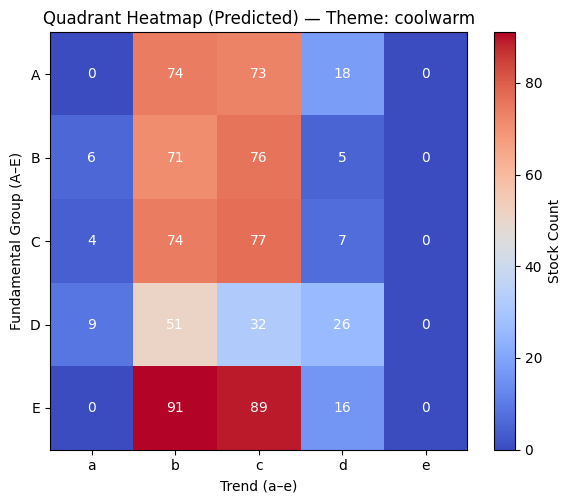


📊 Quadrant Count Matrix:
Trend        a   b   c   d  e
Fundamental                  
A            0  74  73  18  0
B            6  71  76   5  0
C            4  74  77   7  0
D            9  51  32  26  0
E            0  91  89  16  0


In [23]:
# ============================================================
# 🔰 Deployment: Predict All Stocks from Excel + Quadrant Heatmap
# ============================================================

import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# -----------------------------
# 1️⃣ โหลดไฟล์ Excel และโมเดล
# -----------------------------
excel_path = "fileformodel.xlsx"
model_path_h5 = "C:/Users/Admin/OneDrive/Desktop/Stock-quadrant-quantitative-analysis-using-deep-learning-classification/1.Final_file/3.Data_preparation,4.Modelling/deploy_model_deep/best_model_deep.h5"
scaler_path = "C:/Users/Admin/OneDrive/Desktop/Stock-quadrant-quantitative-analysis-using-deep-learning-classification/1.Final_file/3.Data_preparation,4.Modelling/deploy_model_deep/scaler.pkl"
le_path = "C:/Users/Admin/OneDrive/Desktop/Stock-quadrant-quantitative-analysis-using-deep-learning-classification/1.Final_file/3.Data_preparation,4.Modelling/deploy_model_deep/label_encoder.pkl"

    

df = pd.read_excel(excel_path)
deep_model = load_model(model_path)
scaler = joblib.load(scaler_path)
le = joblib.load(le_path)

# -----------------------------
# 2️⃣ เตรียมฟีเจอร์ที่ใช้เทรนโมเดล
# -----------------------------
features = [
    "eps", "pe", "pbv", "percentyield", "marketcap",
    "close_price", "high_price", "low_price", "open_price",
    "value", "ema5", "ema15", "ema35", "ema89", "ema200", "rsi"
]

# ตรวจสอบว่าฟีเจอร์ครบไหม
missing = [f for f in features if f not in df.columns]
if missing:
    raise ValueError(f"❌ ขาดคอลัมน์: {missing}")

# -----------------------------
# 3️⃣ เตรียมข้อมูลและสเกล
# -----------------------------
X = df[features].replace([np.inf, -np.inf], np.nan)
for c in X.columns:
    X[c] = X[c].fillna(X[c].median())

X_scaled = scaler.transform(X)

# -----------------------------
# 4️⃣ ทำนาย Quadrant ทั้งหมด
# -----------------------------
y_pred = deep_model.predict(X_scaled)
y_class = np.argmax(y_pred, axis=1)
df["Predicted Quadrant"] = le.inverse_transform(y_class)

# -----------------------------
# 5️⃣ บันทึกผลลัพธ์ทั้งหมด
# -----------------------------
output_file = "predicted_quadrants.xlsx"
df.to_excel(output_file, index=False)
print(f"✅ Saved prediction results to: {output_file}")
# -----------------------------
# 6️⃣ สร้างตารางนับจำนวนหุ้นแต่ละ Quadrant
# -----------------------------
# แยก Quadrant ออกเป็น 2 ส่วน เช่น A–E และ a–e
df["Fundamental"] = df["Predicted Quadrant"].str[0]
df["Trend"] = df["Predicted Quadrant"].str[1]

financial_levels = ["A", "B", "C", "D", "E"]
trend_levels = ["a", "b", "c", "d", "e"]

# สร้าง pivot table เพื่อนับจำนวนในแต่ละ Quadrant
heatmap_data = pd.pivot_table(
    df,
    index="Fundamental",
    columns="Trend",
    values="symbol",
    aggfunc="count",
    fill_value=0
).reindex(index=financial_levels, columns=trend_levels, fill_value=0)

# -----------------------------
# 7️⃣ วาด Heatmap (กำหนดโทนสีเอง)
# -----------------------------
import matplotlib.pyplot as plt
import numpy as np


color_theme = "coolwarm"

fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(heatmap_data.values, cmap=color_theme)

# ตั้งค่าฉลากแกน
ax.set_xticks(np.arange(len(trend_levels)))
ax.set_yticks(np.arange(len(financial_levels)))
ax.set_xticklabels(trend_levels)
ax.set_yticklabels(financial_levels)
ax.set_xlabel("Trend (a–e)")
ax.set_ylabel("Fundamental Group (A–E)")
ax.set_title(f"Quadrant Heatmap (Predicted) — Theme: {color_theme}")

# ใส่จำนวนในแต่ละช่อง
for i in range(len(financial_levels)):
    for j in range(len(trend_levels)):
        ax.text(j, i, int(heatmap_data.values[i, j]), ha="center", va="center", color="white", fontsize=10)

# เพิ่มแถบสีด้านข้าง
cbar = plt.colorbar(im)
cbar.set_label("Stock Count")

plt.tight_layout()
plt.show()


# แสดงตารางสรุปจำนวนหุ้นแต่ละ Quadrant
print("\n📊 Quadrant Count Matrix:")
print(heatmap_data)


In [24]:
df_original = pd.read_excel("stock_all_data.xlsx")
df_predicted =df

In [25]:
df.columns

Index(['symbol', 'eps', 'pe', 'pbv', 'percentyield', 'volume', 'marketcap',
       'score', 'time', 'close_price', 'high_price', 'low_price', 'open_price',
       'value', 'ema5', 'ema15', 'ema35', 'ema89', 'ema200', 'rsi',
       'Predicted Quadrant', 'Fundamental', 'Trend'],
      dtype='object')

In [26]:
merged = pd.merge(
    df_original,
    df_predicted[["symbol", "Predicted Quadrant"]],
    on="symbol",
    how="inner",
    suffixes=("_actual", "_predicted")
)

# -----------------------------
# 3️⃣ เปรียบเทียบ Quadrant เดิม vs ทำนาย
# -----------------------------
merged["Match"] = merged.apply(
    lambda x: "✅ Same" if x["quadrant"] == x["Predicted Quadrant"] else "❌ Different",
    axis=1
)

# -----------------------------
# 4️⃣ แสดงผลการเปรียบเทียบ
# -----------------------------
comparison = merged[["symbol", "quadrant", "Predicted Quadrant", "Match"]]
print(comparison)

# -----------------------------
# 5️⃣ นับจำนวนที่ตรง / ไม่ตรง
# -----------------------------
summary = comparison["Match"].value_counts()
print("\n📊 Summary:")
print(summary)

    symbol quadrant Predicted Quadrant        Match
0     PPPM       Dd                 Ec  ❌ Different
1     TPCH       Ac                 Ac       ✅ Same
2     POLY       Ac                 Ac       ✅ Same
3     VCOM       Ab                 Ab       ✅ Same
4      NVD       Ed                 Ec  ❌ Different
..     ...      ...                ...          ...
794    TFM       Ab                 Ab       ✅ Same
795  TRITN       Ed                 Ec  ❌ Different
796     I2       Bd                 Bc  ❌ Different
797   SPRC       Bd                 Bc  ❌ Different
798  BLAND       Db                 Db       ✅ Same

[799 rows x 4 columns]

📊 Summary:
Match
✅ Same         537
❌ Different    262
Name: count, dtype: int64


In [27]:
# -----------------------------
# 2️⃣ รวมข้อมูลโดยใช้ Symbol เป็นกุญแจ
# -----------------------------
merged = pd.merge(
    df_original,
    df_predicted[["symbol", "Predicted Quadrant"]],
    on="symbol",
    how="inner",
    suffixes=("_actual", "_predicted")
)

# -----------------------------
# 3️⃣ สร้างคอลัมน์เปรียบเทียบ
# -----------------------------
merged["Match"] = merged.apply(
    lambda x: "✅ Same" if x["quadrant"] == x["Predicted Quadrant"] else "❌ Different",
    axis=1
)

# -----------------------------
# 4️⃣ เลือกเฉพาะคอลัมน์สำคัญและเก็บเป็น DataFrame
# -----------------------------
comparison_df = merged[["symbol", "quadrant", "Predicted Quadrant", "Match"]]

# ✅ แสดง DataFrame (หรือใช้ในขั้นตอนต่อไป)
comparison_df


,symbol,quadrant,Predicted Quadrant,Match
0,PPPM,Dd,Ec,❌ Different
1,TPCH,Ac,Ac,✅ Same
2,POLY,Ac,Ac,✅ Same
3,VCOM,Ab,Ab,✅ Same
4,NVD,Ed,Ec,❌ Different
...,...,...,...,...
794,TFM,Ab,Ab,✅ Same
795,TRITN,Ed,Ec,❌ Different
796,I2,Bd,Bc,❌ Different
797,SPRC,Bd,Bc,❌ Different


In [28]:
symbols = ["DELTA", "PTT", "AOT", "ADVANC", "KBANK", 
           "TRUE", "GULF", "SCB", "KTC", "KTB", "CPALL"]

df_filtered = comparison_df[comparison_df['symbol'].isin(symbols)]

df_filtered.head(11)

,symbol,quadrant,Predicted Quadrant,Match
67,KBANK,Ab,Ab,✅ Same
169,CPALL,Ab,Ab,✅ Same
279,PTT,Ab,Ab,✅ Same
290,AOT,Ab,Ab,✅ Same
343,KTC,Ab,Ab,✅ Same
402,TRUE,Ad,Ad,✅ Same
582,DELTA,Ab,Ab,✅ Same
697,SCB,Ab,Ab,✅ Same
759,KTB,Ab,Ab,✅ Same
788,ADVANC,Ac,Ac,✅ Same


In [29]:
comparison_df.shape

(799, 4)

In [30]:
# -----------------------------
# ✅ รวมสรุปจำนวน
# -----------------------------
summary_df = (
    comparison_df["Match"]
    .value_counts()
    .rename_axis("Category")
    .reset_index(name="Count")
)

# -----------------------------
# ✅ แสดงผลทั้งหมด (ใช้ใน Notebook)
# -----------------------------
print("📘 Summary:")
display(summary_df)


📘 Summary:


,Category,Count
0,✅ Same,537
1,❌ Different,262


In [31]:
total = 799
same = 537
diff = 262

accuracy = (same / total) * 100
error = (diff / total) * 100

print(f"✅ Accuracy: {accuracy:.2f}%")
print(f"❌ Error: {error:.2f}%")


✅ Accuracy: 67.21%
❌ Error: 32.79%


In [19]:
# ------------------------------------------------
# ✅ นับจำนวน 'Same' / 'Different' แยกตาม Quadrant จริง
# ------------------------------------------------
group_summary = (
    comparison_df
    .groupby(["quadrant", "Match"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# เพิ่มคอลัมน์เปอร์เซ็นต์ความถูกต้องต่อกลุ่ม
group_summary["Total"] = group_summary["✅ Same"] + group_summary["❌ Different"]
group_summary["Accuracy (%)"] = (group_summary["✅ Same"] / group_summary["Total"] * 100).round(2)

# เรียงจาก Accuracy สูง → ต่ำ
group_summary = group_summary.sort_values("Accuracy (%)", ascending=False)

display(group_summary)


Match,quadrant,✅ Same,❌ Different,Total,Accuracy (%)
8,Ca,4,0,4,100.00
12,Da,7,0,7,100.00
17,Eb,65,2,67,97.01
2,Ac,41,4,45,91.11
10,Cc,45,5,50,90.00
9,Cb,60,8,68,88.24
5,Bb,58,8,66,87.88
1,Ab,65,11,76,85.53
6,Bc,46,8,54,85.19
18,Ec,39,11,50,78.00


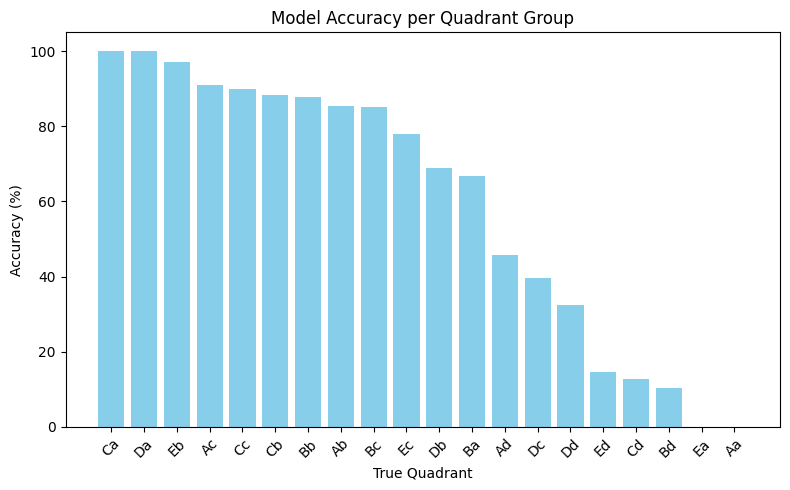

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(group_summary["quadrant"], group_summary["Accuracy (%)"], color="skyblue")
plt.title("Model Accuracy per Quadrant Group")
plt.xlabel("True Quadrant")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [32]:
import plotly.graph_objects as go

df_result3 = comparison_df.copy()

# ✅ จัดกลุ่มหุ้นตาม quadrant
quadrant_groups = df_result3.groupby('Predicted Quadrant')['symbol'].apply(list).to_dict()

financial_levels = ["A", "B", "C", "D", "E"]
trend_levels = ["a", "b", "c", "d", "e"]

# ✅ สร้าง matrix ที่มี 6 คอลัมน์ (Financial + 5 trend)
table_values = []
fill_colors = []

for f in financial_levels:
    row_vals = [f"<b>{f}</b>"]  # label แถว (A–E)
    row_colors = ["#f2f2f2"]    # สีพื้นของ label
    for t in trend_levels:
        code = f + t
        stocks = quadrant_groups.get(code, [])
        if stocks:
            stock_text = "<br>".join([f"{i+1}. {s}" for i, s in enumerate(stocks)])
            cell_text = f"<b>{code}</b><br>{stock_text}"
        else:
            cell_text = f"<b>{code}</b><br>-"
        row_vals.append(cell_text)
        # สีตาม Financial
        color_map = {"A":"#009900","B":"#66cc33","C":"#ffcc00","D":"#ff9933","E":"#ff3333"}
        row_colors.append(color_map[f])
    table_values.append(row_vals)
    fill_colors.append(row_colors)

# ✅ Transpose ให้ตรงกับรูปแบบ cells.values (ต้อง list ตาม column)
values_T = list(map(list, zip(*table_values)))
colors_T = list(map(list, zip(*fill_colors)))

fig = go.Figure(data=go.Table(
    header=dict(
        values=["<b>Financial ↓ / Trend →</b>"] + [f"<b>{t}</b>" for t in trend_levels],
        fill_color="#dcdcdc",
        align="center",
        font=dict(color="black", size=18)
    ),
    cells=dict(
        values=values_T,
        fill_color=colors_T,
        align="center",
        height=160,
        font=dict(color="black", size=13)
    )
))

# ✅ เพิ่มชื่อกราฟและ Legend
fig.update_layout(
    title=dict(
        text=(
            "<b style='font-size:28px;'>Quadrant stock level</b><br>"
            "<span style='font-size:16px;'>"
            "Financial → A=ยอดเยี่ยม | B=ดี | C=ปานกลาง | D=ไม่ค่อยดี | E=แย่<br>"
            "Trend → a=Super bullish | b=Up trend | c=Side way | d=Down trend | e=Crash"
            "</span>"
        ),
        x=0.5, xanchor="center", yanchor="top"
    ),
    margin=dict(l=20, r=20, t=230, b=20),
    height=1150,
    width=1300,
    paper_bgcolor="white"
)

fig.show()